Research Article 

"Classifying DNA barcode sequences of four Orthoptera orders of insects using Tensor Network"

Classification with 3 MPS units

In [1]:
# libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")

# %matplotlib inline

In [2]:
from MPS_general import *

In [3]:
### importing data frame for training data 

data_df = pd.read_csv("Train_sequences.csv", index_col=0)
data_df

,seqlen,seq,label
0,552,CAAATCTATAATGTTATTATTACAGCACATGCATTTGTAATAATTT...,3
1,672,GATATTGGCACACTATACTTTATCTTTGGAACATGAGCCGGGATAG...,1
2,592,TTTTTGAGGAGCTACAGTAATTACAAATTTACTTTCAGCTGTACCT...,2
3,552,TTCATCTTCGGGTTTTGATCTGGAATAGTGGGTACCTCTTTAAGAA...,0
4,658,AACCTTATATTTCATTTTTGGAGCATGAGCAGGAATAGTGGGTACA...,2
...,...,...,...
3995,651,TACCTTATATTTTATATTTGGAGCATGAGCTGGAATAGTAGGAACT...,3
3996,666,TGTAATCTTAATACCTCATTTTTTGATCCAGCAGGAGGGGGAGATC...,3
3997,582,ACATTATACTTTATTTTCGGGGCATGAGCAGGAATAGTAGGTACTT...,2
3998,564,GGAATAGTAGGTACCTCTTTAAGTATATTAATCCGAATAGAACTAG...,0


In [4]:
# SEQ and  Label data for machine learning 

seq_data = data_df['seq'].values
label_data =  data_df['label'].values
print(len(seq_data), len(label_data))

4000 4000


# Kmer

In [5]:
Ksize = 5

def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

data_df['kmer'] = data_df.apply(lambda x: getKmers(x['seq'],size = Ksize), axis=1)

data_df['kmer_len'] = data_df.apply(lambda x: len(x['kmer']), axis=1)

seq_kmer = data_df['kmer'].values
label_data = data_df['label'].values
unique =  set( [i for j in list(seq_kmer) for i in j])


## Parameters

In [6]:



n_features =  1200 # number of words
# n_features =  len(unique)+1
#######################
#########################


pad_len = 699
word_dim = 2  # embedding dimension for kmer
units = 3  # number of units in TN
in_dim = int(pad_len*word_dim/units)  #  physical dimension
bond_dim = 2
out_dim= 4  # number of classes 

epochs = 20
batch_size = 20



In [7]:
# converting text to  number tokens using tokenizer


tokenizer = Tokenizer(num_words=n_features)

tokenizer.fit_on_texts(seq_kmer)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(seq_kmer)
# sequences
# word_index


padded_sequences = pad_sequences(sequences, maxlen=pad_len, padding='post')


X_train = np.asarray(padded_sequences).astype(np.float32)
Y_train = np.asarray(label_data).astype(np.float)

In [8]:

## Tensor network model
model = tf.keras.Sequential([
    Embedding(n_features, word_dim,input_length=pad_len),  # Embedding layer
    TNLayer(units=units,in_dim= in_dim, out_dim=out_dim,bond_dim=bond_dim), # TN layer
    ])

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train,Y_train,batch_size = batch_size,validation_split =0.2,  epochs= epochs)

    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 699, 2)            2400      
_________________________________________________________________
tn_layer (TNLayer)           (None, 4)                 9324      
Total params: 11,724
Trainable params: 11,724
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
160/160 [==============================] - 1s 2ms/step - loss: 0.9335 - accuracy: 0.6278 - val_loss: 0.5574 - val_accuracy: 0.7962
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.4208 - accuracy: 0.8572 - val_loss: 0.4201 - val_accuracy: 0.8375
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.2866 - accuracy: 0.8894 - val_loss: 0.3705 - val_accuracy: 0.8675
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.2129 - accur

(0.0, 22.0)

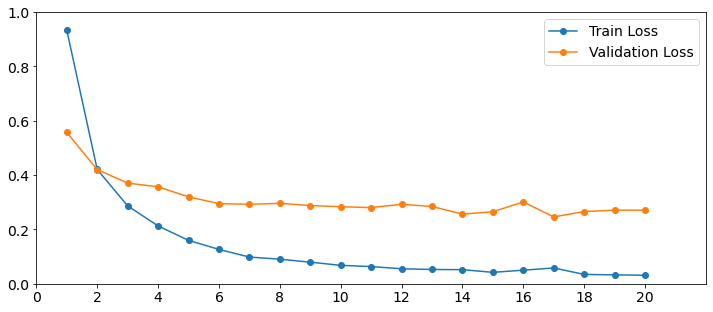

In [9]:
# plot Loss
plt.figure(figsize=(12,5))
plt.plot(list(range(1,epochs+1)),history.history['loss'], '-o', label='Train Loss')
plt.plot(list(range(1,epochs+1)),history.history['val_loss'],'-o', label='Validation Loss')
plt.legend(prop= {'size':14})
plt.xticks(list(range(0,epochs+1,2)),size=14)
plt.yticks(size=14)
plt.ylim(0,1)
plt.xlim(0,22)

(0.5, 1.0)

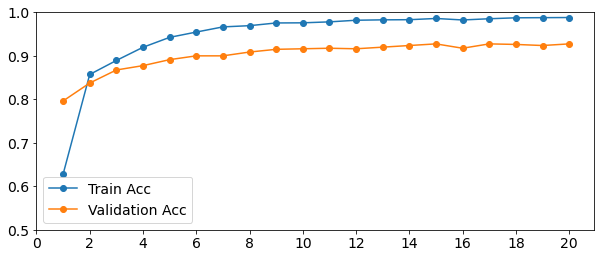

In [10]:
# plot accuracy 
plt.figure(figsize=(10,4))
plt.plot(list(range(1,epochs+1)),history.history['accuracy'], '-o', label='Train Acc')
plt.plot(list(range(1,epochs+1)),history.history['val_accuracy'],'-o', label='Validation Acc')
plt.legend(prop= {'size':14})
plt.xticks(list(range(0,epochs+1,2)),size=14)
plt.yticks(size=14)
plt.ylim(0.5,1)

## Testing

In [11]:
### importing test data 

data_test = pd.read_csv("Test_sequences.csv", index_col=0)

# testing data
test_seq = data_test['seq'].values
test_label =  data_test['label'].values

# 
kmer_data_test = [getKmers(i,size = Ksize) for i in test_seq]
# kmer_data

test_seq =  tokenizer.texts_to_sequences(kmer_data_test)
test_seq = pad_sequences(test_seq, maxlen=pad_len, padding= 'post')


## Predictions 

all_predictions = [] 
for i in  test_seq:
    predict = np.argmax(model.predict((i.reshape(1,-1))))
    all_predictions.append(predict)

# confusion matrix 
import sklearn.metrics

cm = sklearn.metrics.confusion_matrix(test_label.astype('int'), np.array(all_predictions), normalize='true')
df_confusion = pd.DataFrame(cm, columns= ['Cricket', 'Cave cricket', 'Katydidas', 'Grasshopper'], index= ['Cricket', 'Cave cricket', 'Katydidas', 'Grasshopper'])

df_confusion.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\User\AppData\Local\Temp/ipykernel_3320/3116253623.py:30: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_confusion.style.background_gradient(cmap='coolwarm').set_precision(2)


,Cricket,Cave cricket,Katydidas,Grasshopper
Cricket,0.95,0.01,0.04,0.01
Cave cricket,0.01,0.92,0.01,0.07
Katydidas,0.03,0.01,0.92,0.04
Grasshopper,0.01,0.01,0.03,0.95
